<a href="https://colab.research.google.com/github/rubenvangenugten/autobiographical_interview_scoring/blob/main/automated_autobiographical_interview_scoring_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome!

Please read through the .readme file on github to ensure your data is in the correct format. 


To use this code, you'll first have to tell colab where to find your data. You can find the location of your data folder on google drive by clicking (single-click) on the folder and looking at the bottom of your screen. At the bottom, you should see something like:

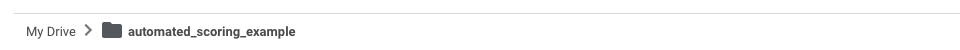

The folder location is '/content/drive/' plus whatever is at the bottom of the screen. So, in this case, '/content/drive/MyDrive/automated_scoring_example/'

Edit the cell below to provide the data file location and the location where you want the results stored.


In [ ]:
data_location = '/content/drive/MyDrive/automated_scoring_example/example.csv'
output_location = '/content/drive/MyDrive/automated_scoring_example/'

Now, to run the code, click 'runtime' -> 'run all' in your menu bar. You'll be prompted for google drive login, which colab needs to access your file. Once the code is done running, you should be able to find the results in the location you set in output_location

# Unless you want to customize something, you should not have to edit the code below.

The cell below allows colab to access google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The code below installs necessary libraries

In [ ]:
pip install transformers==4.6.0

In [ ]:
pip install pysbd

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import pysbd
import re
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

define sentence segmenter so that it's easier to use later


In [ ]:
seg = pysbd.Segmenter(language="en", clean=False)

Reload model trained on all datasets. 
Reload tokenizer saved with it (just standard distilbert tokenizer). These are stored on the huggingface model hub and can be accessed directly with code below

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained("vangenugtenr/autobiographical_interview_scoring")
tokenizer = AutoTokenizer.from_pretrained("vangenugtenr/autobiographical_interview_scoring")

Some layers from the model checkpoint at vangenugtenr/autobiographical_interview_scoring were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at vangenugtenr/autobiographical_interview_scoring and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Read in data from the location provided at the top of this notebook

In [ ]:
allDat = pd.read_csv(data_location)

Now, take each narrative and split it up into sentences. We do this because sentences are the level at which we classify content. We want to end up with a new dataframe in which each row contains participantID, prompt, text, and one  sentence. So let's say we start with two initial rows of data: two narratives. Let's say that each has ten sentences. After the code below, our resulting dataframe should be 20 rows long.

This way, the sentences can easily be classified and are matched to the stories they came from.

Approach:

Loop through each narrative, create a new dataframe where each row contains the participantID, prompt, text, and one of the resulting sentences. Store this dataframe. At the end, bind all dataframes together. This way, we obtain a dataframe with all narratives in long format, where each row has a sentence that can be classified.

In [ ]:
list_of_dataframes = []

for row in range(allDat.shape[0]):
    
    # access some general info about this narrative
    this_subID = allDat.iloc[row, allDat.columns.get_loc("participantID")]
    this_prompt = allDat.iloc[row, allDat.columns.get_loc("prompt")]
    narrative = allDat.iloc[row, allDat.columns.get_loc("text")]

    # store current row
    currentRow = allDat.iloc[[row], :] # if don't have brackets around row, not returned as Df, which is needed for merge

    # create new dataframe with each row a new sentence, and subID and prompt added
    segmented_sentences = seg.segment(narrative)
    sentences_df = pd.DataFrame(segmented_sentences, columns=['sentence'])
    sentences_df["participantID"] = this_subID
    sentences_df["prompt"] = this_prompt

    # create a new merged dataframe 
    merged_thisNarrative = pd.merge(currentRow, sentences_df, on=["participantID", "prompt"])

    list_of_dataframes.append(merged_thisNarrative)
  

testData = pd.concat(list_of_dataframes)


Now, prepare the data so that it can passed to our model

In [ ]:
# now, make sure data are character

testData.loc[:,'sentence'] = testData.loc[:,'sentence'].astype('str')
        
# create list of texts to classify (put in list format to encode texts)
    
test_texts = []

for row2 in range(testData.shape[0]):
    temp_test = testData.iloc[row2, testData.columns.get_loc("sentence")]
    temp_test = str(temp_test) # strip name of dataframe, then turn into string
    test_texts.append(temp_test)


# encode text into something that bert can work with.

test_encodings = tokenizer(test_texts, truncation=True, padding=True)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings)
))

Classify each sentence

In [ ]:
# set up text classification pipeline using our model and tokenizer

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# to keep amount of ram low, so that we can use the free version of
# google colab, split classification up into batches rather than all
# sentences at once.

stored_test = []
batch_size = 200  

for i in range(0, len(test_texts), batch_size):
   stored_test.extend(pipe(test_texts[i:i+batch_size]))

After the step above, predicted labels are stored in a list format. We'd like to work with a dataframe of predictions. So just loop through each list and turn it into a dataframe, then put them all together

In [ ]:
list_of_predictionDfs = []

for row in range(len(stored_test)):
    
    thisTestLabels = pd.DataFrame(stored_test[row]) 
    thisTestLabels.index = thisTestLabels['label']
    thisTestLabels = thisTestLabels.drop('label', axis = 1)
    thisTestLabels = thisTestLabels.transpose()

    list_of_predictionDfs.append(thisTestLabels)

predictionsDf = pd.concat(list_of_predictionDfs)

Identify which label was most likely for the text

In [ ]:
predictionsDf['toplabel'] = predictionsDf.idxmax(axis=1)

Merge predictions dataframe with the long dataframe to obtain one large dataframe

In [ ]:
testData2 = pd.concat([testData.reset_index(drop=True), predictionsDf.reset_index(drop=True)], axis=1)

Add a wordcount for each sentence. use for loop for readability (plus, takes no time)

In [ ]:
testData2[['sentenceWordCount']] = 0

for row in range(testData2.shape[0]):
  line = testData2.iloc[row, testData2.columns.get_loc("sentence")]
  count = len(re.findall(r'\w+', line))
  testData2.iloc[row, testData2.columns.get_loc("sentenceWordCount")] = count

Create two new columns: number of words classified as internal, and number of words classified as external. Fill in those columns. As a reminder from the paper, each sentence is classified as containing 0% internal data (i.e. 100% external data), 50% internal, 75% internal, and 100% internal data.

In [ ]:
testData2[['numInt_preds']] = 0
testData2[['numExt_preds']] = 0

# now loop through each row and add in the counts

for row in range(testData2.shape[0]):
    
    predictionType_thisIter = testData2.iloc[row, testData2.columns.get_loc("toplabel")]
    numTotalWords = testData2.iloc[row, testData2.columns.get_loc("sentenceWordCount")]

    internalLocation = testData2.columns.get_loc("numInt_preds")
    externalLocation = testData2.columns.get_loc("numExt_preds")
    
    if predictionType_thisIter == 'LABEL_0':
        testData2.iloc[row, externalLocation] = numTotalWords

    if predictionType_thisIter == 'LABEL_1':
        halfDetails = numTotalWords/2
        testData2.iloc[row, externalLocation] = halfDetails
        testData2.iloc[row, internalLocation] = halfDetails

    if predictionType_thisIter == 'LABEL_2':
        testData2.iloc[row, externalLocation] = numTotalWords/4
        testData2.iloc[row, internalLocation] = numTotalWords*(3/4)
            
    if predictionType_thisIter == 'LABEL_3':
        testData2.iloc[row, internalLocation] = numTotalWords

We now have the predicted number of internal and exteranl words for each sentence. We are interested in a narrative-level summary. So, have to sum up all internal words per narrative and all external words per narrative. We do that below

In [ ]:
test_write_out_subset = testData2.loc[:,["participantID","prompt", "text","numInt_preds", "numExt_preds", 'sentenceWordCount']]
grouped = test_write_out_subset.groupby(by = ["participantID", "prompt"]).agg({'text': 'first', 
                                            'numInt_preds': 'sum', 
                                            'numExt_preds': 'sum',
                                            'sentenceWordCount': 'sum'})

Since we have summed across sentences, the sentenceWordCount column actually contains the wordcount of the whole narrative. so, just rename sentenceWordCount to totalWordCount, which is more appropriate

In [ ]:
grouped.rename(columns = {"sentenceWordCount": "totalWordCount"}, 
          inplace = True)

Finally, write out data to location specified at the top

In [ ]:
grouped.to_csv(output_location + '/automated_autobio_scored.csv')